## 1. Parameters & Imports

In [ ]:
# must change
repo_id     = "icl-182/poisson-0.32"
ckpt_name   = "state.pt"
loss_type   = "poisson"

# Optional if want test generalizaton 
r_val = 2.5
scale = 0.32

# fixed params
n_tasks     = 10000
n_train     = 40
lr          = 0.05
max_steps   = 100000
tol         = 1e-10

import os, sys, yaml
import torch
from torch.nn import PoissonNLLLoss
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(7)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## 2. Download HF Repo & Load Config

In [3]:
!pip install -q huggingface_hub

from huggingface_hub import snapshot_download
from types import SimpleNamespace

ckpt_dir = snapshot_download(repo_id, repo_type="model")
print("Repo downloaded to:", ckpt_dir)

sys.path.append(ckpt_dir)

cfg = yaml.safe_load(open(os.path.join(ckpt_dir, "config.yaml")))
print("Config keys:", cfg.keys())

model_conf = SimpleNamespace(**cfg["model"])
task_kwargs = cfg["training"]["task_kwargs"]
scale = task_kwargs.get("scaling", 1.0)
r_val = task_kwargs.get("r", None) or r_val
n_train = cfg["model"]["n_positions"]

print(f"n_dims={model_conf.n_dims}, scale={scale}, r={r_val}")

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

model_3000.pt:   0%|          | 0.00/89.6M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/803 [00:00<?, ?B/s]

model_4000.pt:   0%|          | 0.00/89.6M [00:00<?, ?B/s]

model_6000.pt:   0%|          | 0.00/89.6M [00:00<?, ?B/s]

model_5000.pt:   0%|          | 0.00/89.6M [00:00<?, ?B/s]

model_7000.pt:   0%|          | 0.00/89.6M [00:00<?, ?B/s]

state.pt:   0%|          | 0.00/166M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

metrics.json:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

model_2000.pt:   0%|          | 0.00/89.6M [00:00<?, ?B/s]

model_1000.pt:   0%|          | 0.00/89.6M [00:00<?, ?B/s]

Repo downloaded to: /root/.cache/huggingface/hub/models--icl-182--poisson-0.32/snapshots/92bd9305bd51c8b3a41b32722cb985c67c659205
Config keys: dict_keys(['config', 'model', 'out_dir', 'test_run', 'training', 'wandb'])
n_dims=10, scale=0.32, r=2.5


## 3. Sampling & Loss Registry

In [4]:
def sample_data(n_tasks, n_points, d, ws=None, scale=1.0, loss_type="poisson", r=None):
    xs = torch.randn(n_tasks, n_points, d, device=device)
    if ws is None:
        ws = scale * torch.randn(n_tasks, d, 1, device=device)
    logits = (xs @ ws).clamp(-4, 4)
    mu = torch.exp(logits)

    if loss_type == "poisson":
        ys = torch.poisson(mu).squeeze(-1)
    elif loss_type in ("nb", "neg_binomial"):
        r_t = torch.tensor(r, device=device, dtype=mu.dtype)
        logits = torch.log(r_t) - torch.log(mu)
        dist = torch.distributions.NegativeBinomial(total_count=r_t, logits=logits)
        ys = dist.sample().squeeze(-1)
    else:
        raise ValueError(f"Unsupported loss_type: {loss_type}")
    return xs, ys, ws

LOSS_REGISTRY = {}
def register_loss(name):
    def deco(fn):
        LOSS_REGISTRY[name] = fn
        return fn
    return deco

@register_loss("poisson")
def poisson_loss_fn(pred, targets, **kw):
    return PoissonNLLLoss(log_input=True, full=True, reduction="none")(pred, targets)

@register_loss("nb")
def nb_loss_fn(preds, targets, r, **kw):
    mu = torch.exp(preds)
    r_t = torch.tensor(r, device=mu.device, dtype=mu.dtype)
    logits = torch.log(r_t) - torch.log(mu)
    dist = torch.distributions.NegativeBinomial(total_count=r_t, logits=logits)
    return -dist.log_prob(targets)

## 4. Evaluation Routines

In [5]:
from tqdm import tqdm
loss_fn = LOSS_REGISTRY[loss_type]

def get_logits(xs, ws):
    return (xs @ ws).squeeze(-1).clamp(-4, 4)

def evaluate_transformer(model, xs_all, ys_all, loss_type="poisson", r=None):
    model.eval()
    xs_all, ys_all = xs_all.to(device), ys_all.to(device)
    with torch.no_grad():
        out = model(xs_all, ys_all)
        per_pos = loss_fn(out, ys_all, r=r).mean(dim=0)
    return per_pos.cpu().tolist()

def evaluate_oracle_gd(xs_all, ys_all, lr, max_steps, tol, scale=None, r=None, loss_type="poisson"):
    xs_all, ys_all = xs_all.to(device), ys_all.to(device)
    n_tasks, n_points, d = xs_all.shape
    all_losses = []
    loss_fn = LOSS_REGISTRY[loss_type]
    for t in tqdm(range(1, n_points), desc="GD Oracle"):
        xs_tr, ys_tr = xs_all[:, :t, :], ys_all[:, :t]
        xs_te, ys_te = xs_all[:, t:t+1, :], ys_all[:, t:t+1]

        w_hat = torch.randn(n_tasks, d, 1, device=device, requires_grad=True)
        opt = torch.optim.Adam([w_hat], lr=lr)
        prev = float("inf")
        for step in range(max_steps):
            logits = get_logits(xs_tr, w_hat)
            loss = loss_fn(logits, ys_tr, r=r).mean()
            loss = loss + (0.5/scale**2)*w_hat.pow(2).sum()/(n_tasks*t)
            if abs(prev - loss.item()) < tol:
                break
            prev = loss.item()
            opt.zero_grad(); loss.backward(); opt.step()

        with torch.no_grad():
            logits_te = get_logits(xs_te, w_hat)
            all_losses.append(loss_fn(logits_te, ys_te, r=r).mean().item())
    return all_losses

def evaluate_oracle_true(xs_all, ys_all, ws, loss_type="poisson", r=None):
    xs_all, ys_all, ws = xs_all.to(device), ys_all.to(device), ws.to(device)
    losses = []
    for t in range(1, xs_all.shape[1]):
        logits = get_logits(xs_all[:, t:t+1, :], ws)
        losses.append(loss_fn(logits, ys_all[:, t:t+1], r=r).mean().item())
    return losses

def evaluate_naive(ys_all):
    ys_all = ys_all.to(device)
    losses = []
    for t in range(1, ys_all.shape[1]):
        pred = ys_all[:, :t].mean(dim=1, keepdim=True)
        losses.append(loss_fn(torch.log(pred + 1e-4), ys_all[:, t:t+1], r=r_val).mean().item())
    return losses

## 5. Sample Data & Load Model

In [6]:
xs_all, ys_all, ws_true = sample_data(
    n_tasks, n_train, 10, scale=scale, loss_type=loss_type, r=r_val
)
xs_all, ys_all, ws_true = xs_all.to(device), ys_all.to(device), ws_true.to(device)

In [7]:
from models import build_model
ckpt_path = os.path.join(ckpt_dir, ckpt_name)
state = torch.load(ckpt_path, map_location=device)
model = build_model(model_conf).to(device)
print("Loading", ckpt_name)
model.load_state_dict(state.get("model_state_dict", state))
print("Running transformer...")
trans_losses = evaluate_transformer(model, xs_all, ys_all, loss_type, r_val)

Loading state.pt
Running transformer...


## 6. Run Baselines & GD‑Oracle

In [8]:
print("Running GD‑oracle…")
gd_losses = evaluate_oracle_gd(xs_all, ys_all, lr, max_steps, tol, scale=scale, r=r_val, loss_type=loss_type)
print("Running true‑weights oracle…")
true_losses = evaluate_oracle_true(xs_all, ys_all, ws_true, loss_type, r_val)
print("Running naive baseline…")
naive_losses = evaluate_naive(ys_all)

Running GD‑oracle…


GD Oracle: 100%|██████████| 39/39 [02:09<00:00,  3.33s/it]

Running true‑weights oracle…
Running naive baseline…


In [50]:
gd_losses

[4.057886600494385,
 4.0271148681640625,
 3.9272620677948,
 3.6832849979400635,
 3.8094286918640137,
 3.698178768157959,
 3.646193742752075,
 3.58614182472229,
 3.559831142425537,
 3.4596030712127686,
 3.408914089202881,
 3.3398678302764893,
 3.3725874423980713,
 3.304672956466675,
 3.3102593421936035,
 3.2680134773254395,
 3.2113020420074463,
 3.2391648292541504,
 3.199352741241455,
 3.1411361694335938,
 3.1592893600463867,
 3.1767261028289795,
 3.1077427864074707,
 3.131904363632202,
 3.1095550060272217,
 3.106755018234253,
 3.0937366485595703,
 3.0776872634887695,
 3.0767807960510254,
 3.0784058570861816,
 3.0547361373901367,
 3.054682970046997,
 3.0455002784729004,
 3.0223169326782227,
 3.061467409133911,
 3.0117685794830322,
 3.029967784881592,
 3.012407064437866,
 2.992009401321411]

## 7. Plot All Results

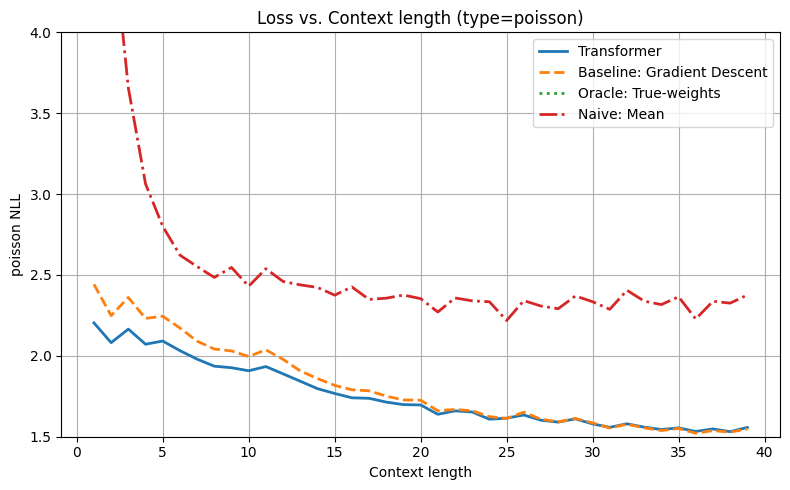

In [ ]:
loss_to_name = {
    "poisson": "Poisson",
    "nb": "Negative Binomial",
}

title = 
f"Loss vs. Context length (type={loss_type})"

ctx = list(range(1, n_train))
plt.figure(figsize=(8,5))
plt.plot(ctx, trans_losses[1:], label="Transformer", linewidth=2)
plt.plot(ctx, gd_losses,    label="Baseline: Gradient Descent", linestyle="--", linewidth=2)
plt.plot(ctx, true_losses,  label="Oracle: True‑weights", linestyle=":", linewidth=2)
plt.plot(ctx, naive_losses, label="Naive: Mean", linestyle="-.", linewidth=2)
plt.xlabel("Context length")
plt.ylabel(f"{loss_type} NLL")
plt.title(f"Loss vs. Context length (type={loss_type})")
plt.legend(loc="upper right")
plt.ylim(1.5, 4)
plt.grid(True)
plt.tight_layout()
plt.show()